<a href="https://colab.research.google.com/github/Songhyunjeong/thingplug-lora-starter-kit/blob/master/bus_%EB%85%B8%EC%84%A0%EB%B3%84_%EC%8A%B9%ED%95%98%EC%B0%A8%ED%99%98%EC%8A%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install plotly
!pip install pydeck

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.2 MB/s eta 0:00:00


In [28]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

font_family = 'NanumGothic'
font_family

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 34.1 MB/s eta 0:00:00


'NanumGothic'

In [3]:
import os

# for data aggregation.
import numpy as np
import pandas as pd
import geopandas as gpd

# for data visualisation.
import missingno as msno
import plotly.express as px
#import plotly.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')
import pydeck as pdk
#from deckgljupyter import Layer as deckgl
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

access_token = os.getenv('pk.eyJ1IjoicG9zdHBpYSIsImEiOiJjbHZ4NTgwbmEyYXJuMnFtZ3Z1d3dxZml5In0.RA9jCssKIoSK-lUozuP9_A')
view_options = {
    'center': [126.908, 37.132],
    'zoom': 12,
    'bearing': 0,
    'pitch': 60,
    'style': 'mapbox://styles/mapbox/dark-v9',
    'access_token': access_token
}

plotly_kwargs = {
    'margin' : {'l':250},
    'dimensions': (1000, 600)
}


In [5]:
import pandas as pd
import pydeck as pdk
import random
# 예시 데이터프레임 생성
bus_stops_data = pd.read_csv('/content/drive/MyDrive/my_project/GGD_StationInfo_M.csv')
passenger_data1 = pd.read_csv('/content/drive/MyDrive/my_project/3_20240812.csv')
passenger_data2 = pd.read_csv('/content/drive/MyDrive/my_project/66_20240812.csv')
passenger_data3 = pd.read_csv('/content/drive/MyDrive/my_project/23_2_20240812.csv')
passenger_data4 = pd.read_csv('/content/drive/MyDrive/my_project/75_20240812.csv')
passenger_data5 = pd.read_csv('/content/drive/MyDrive/my_project/83_20240812.csv')
passenger_data6 = pd.read_csv('/content/drive/MyDrive/my_project/12_20240812.csv')
passenger_data1['노선']='3'
passenger_data2['노선']='66'
passenger_data3['노선']='23_2'
passenger_data4['노선']='75'
passenger_data5['노선']='83'
passenger_data6['노선']='12'
passenger_data = pd.concat([passenger_data1, passenger_data2,passenger_data3,passenger_data4,passenger_data5,passenger_data6])

# DataFrame 생성
bus_stops_df = pd.DataFrame(bus_stops_data)
passenger_df = pd.DataFrame(passenger_data)

# 중복된 '정류소명'을 제거하고 첫 번째 값만 유지
bus_stops_df_unique = bus_stops_df.drop_duplicates(subset=['STATION_NM'], keep='first')

# 데이터프레임 병합
merged_df = pd.merge(bus_stops_df_unique, passenger_df, left_on='STATION_NM', right_on='정류장', how='right')

# 각 노선명에 대해 랜덤 색상을 지정하는 함수 정의
def generate_random_color():
    return [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), 160]

# 노선명별로 색상을 지정하는 딕셔너리 생성
route_colors = {route: generate_random_color() for route in merged_df['노선'].unique()}

# 노선명에 따라 색상 지정
merged_df['색상'] = merged_df['노선'].map(route_colors)
merged_df['합계'] = pd.to_numeric(merged_df['합계'], errors='coerce')

# 노선명에 따라 위치 오프셋 설정
offsets = {
    '3': (0.0001, 0.0001),
    '66': (0.0001, -0.0001),
    '23_2': (-0.0001, 0.0001),
    '75': (-0.0001, -0.0001),
    '83': (0.0001, 0)
}

# 노선별 위치 오프셋 적용
def apply_offset(row):
    offset = offsets.get(row['노선'], (0, 0))
    return [row['X'] + offset[0], row['Y'] + offset[1]]

merged_df['위치_오프셋'] = merged_df.apply(apply_offset, axis=1)

# Calculate average passenger count per route
route_avg = merged_df.groupby('노선')['합계'].mean().reset_index()
route_avg.columns = ['노선', '평균_승객수']

# Merge to get only bus stops with passenger counts above the average
merged_with_avg = pd.merge(merged_df, route_avg, on='노선', how='left')
above_avg_df = merged_with_avg[merged_with_avg['합계'] > merged_with_avg['평균_승객수']]

# Pydeck visualization setup
view_state = pdk.ViewState(
    latitude=merged_df['Y'].mean(),
    longitude=merged_df['X'].mean(),
    zoom=12,
    pitch=50
)

# Layer for all stops
boardings_layer = pdk.Layer(
    'ColumnLayer',
    data=merged_df,
    get_position='위치_오프셋',
    get_elevation='합계',
    elevation_scale=1,
    radius=20,
    get_fill_color='색상',
    pickable=True,
    auto_highlight=True
)

# Layer for stops above average
above_avg_layer = pdk.Layer(
    'ScatterplotLayer',
    data=above_avg_df,
    get_position='위치_오프셋',
    get_radius=50,
    get_fill_color=[255, 0, 0],  # Red color to highlight
    pickable=True,
    auto_highlight=True
)

# Tooltip definition
tooltip = {
    "html": "<b>정류소명:</b> {STATION_NM}<br/>"
            "<b>승차 승객 수:</b> {합계}<br/>"
            "<b>노선:</b> {노선}<br/>"
          ,
    "style": {"color": "white"}
}

# Deck creation
r = pdk.Deck(
    layers=[boardings_layer, above_avg_layer],
    initial_view_state=view_state,
    tooltip=tooltip
)

# Show map
r.show()

<IPython.core.display.Javascript object>

In [10]:
import pandas as pd

# 3번 버스노선의 경유정류장 데이터 (가정)
bus_stops_data = pd.read_csv("/content/drive/MyDrive/my_project/23_2_bus.csv")

# DataFrame 생성
stops_df = pd.DataFrame(bus_stops_data)

# 'Column1.6.2'를 정수로 변환하여 'sttnld' 열 생성
stops_df['Column1.6.2'] = pd.to_numeric(stops_df['Column1.6.2'], errors='coerce')  # 문자열을 숫자로 변환하며 오류 무시
stops_df['Column1.6.2'].fillna(0, inplace=True)  # NaN을 0으로 대체
stops_df['sttnld'] = stops_df['Column1.6.2'].astype(int)

# 기존 노선별 정류소 이용 데이터 예시
usage_data = pd.read_csv("/content/drive/MyDrive/my_project/0701_bus.csv")


usage_df = pd.DataFrame(usage_data)

# 3번 버스 노선의 데이터 필터링
route_3_usage = usage_df[usage_df['rte_id_fadjco'] == 41030017]

# 승차 정류소별 이용자 수 계산
gon_counts_3 = route_3_usage.groupby('gon_stop_id_fadjco')['pssgr_cnt_van'].sum().reset_index()
gon_counts_3.columns = ['sttnld', 'gon_pssgr_cnt']

# 하차 정류소별 이용자 수 계산
goff_counts_3 = route_3_usage.groupby('goff_stop_id_fadjco')['pssgr_cnt_van'].sum().reset_index()
goff_counts_3.columns = ['sttnld', 'goff_pssgr_cnt']

# 승차 및 하차 데이터를 통합
combined_counts_3 = pd.merge(gon_counts_3, goff_counts_3, on='sttnld', how='outer').fillna(0)

# 정류소 순서대로 정렬 (이 예제에서는 이미 정렬된 상태)
#sorted_combined_counts_3
combined_counts_3.sort_values('sttnld', inplace=True)

# 남은 승객 수 계산을 위한 열 추가
combined_counts_3['remaining_pssgr'] = 0

# 첫 번째 정류소의 남은 승객 수는 승차 인원
combined_counts_3.iloc[0, combined_counts_3.columns.get_loc('remaining_pssgr')] = combined_counts_3.iloc[0]['gon_pssgr_cnt']

# 남은 승객 수 누적 계산
for i in range(1, len(combined_counts_3)):
    prev_remaining = combined_counts_3.iloc[i-1]['remaining_pssgr']
    current_gon = combined_counts_3.iloc[i]['gon_pssgr_cnt']
    current_goff = combined_counts_3.iloc[i]['goff_pssgr_cnt']
    combined_counts_3.iloc[i, combined_counts_3.columns.get_loc('remaining_pssgr')] = prev_remaining + current_gon - current_goff

# 결과 출력
print(combined_counts_3)

       sttnld  gon_pssgr_cnt  goff_pssgr_cnt  remaining_pssgr
0   4100304.0           20.0            61.0               20
1   4100307.0           78.0            80.0               18
2   4100308.0          110.0            60.0               68
3   4100318.0           69.0            50.0               87
4   4100319.0           78.0            71.0               94
..        ...            ...             ...              ...
76  4196605.0          136.0           270.0               74
77  4196606.0           22.0            18.0               78
78  4196607.0           87.0           152.0               13
79  4196649.0          213.0            43.0              183
80  4199634.0           84.0           117.0              150

[88 rows x 4 columns]


In [11]:
combined_counts_3.head(100)

,sttnld,gon_pssgr_cnt,goff_pssgr_cnt,remaining_pssgr
0,4100304.0,20.0,61.0,20
1,4100307.0,78.0,80.0,18
2,4100308.0,110.0,60.0,68
3,4100318.0,69.0,50.0,87
4,4100319.0,78.0,71.0,94
...,...,...,...,...
76,4196605.0,136.0,270.0,74
77,4196606.0,22.0,18.0,78
78,4196607.0,87.0,152.0,13
79,4196649.0,213.0,43.0,183


In [16]:

# 'sttnld' 열을 정수형으로 변환
combined_counts_3['sttnld'] = combined_counts_3['sttnld'].astype(int)
# 'sttnSeq'를 정수형으로 변환 (변환할 수 없는 값은 NaN으로 처리한 후, 0으로 대체)
stops_df['sttnSeq'] = stops_df['Column1.5'].apply(lambda x: int(str(x).split(":")[1]) if isinstance(x, str) and ":" in x else None).fillna(0).astype(int)

# 'sttnld' 열을 정수형으로 변환
combined_counts_3['sttnld'] = combined_counts_3['sttnld'].astype(int)
stops_df['sttnld'] = stops_df['sttnld'].fillna(0).astype(int)

# combined_counts_3을 정류장 순서대로 정렬
sorted_combined_counts_3 = pd.merge(stops_df, combined_counts_3, on='sttnld', how='left').sort_values('sttnSeq').reset_index(drop=True)

# NaN 값 0으로 대체
sorted_combined_counts_3[['gon_pssgr_cnt', 'goff_pssgr_cnt']] = sorted_combined_counts_3[['gon_pssgr_cnt', 'goff_pssgr_cnt']].fillna(0)

# 남은 승객 수 계산
sorted_combined_counts_3['remaining_pssgr'] = 0
for i in range(len(sorted_combined_counts_3)):
    if i == 0:
        sorted_combined_counts_3.at[i, 'remaining_pssgr'] = sorted_combined_counts_3.at[i, 'gon_pssgr_cnt']
    else:
        sorted_combined_counts_3.at[i, 'remaining_pssgr'] = sorted_combined_counts_3.at[i-1, 'remaining_pssgr'] + sorted_combined_counts_3.at[i, 'gon_pssgr_cnt'] - sorted_combined_counts_3.at[i, 'goff_pssgr_cnt']

# 결과 출력
print(sorted_combined_counts_3[['sttnSeq', 'sttnld', 'gon_pssgr_cnt', 'goff_pssgr_cnt', 'remaining_pssgr']])

    sttnSeq   sttnld  gon_pssgr_cnt  goff_pssgr_cnt  remaining_pssgr
0         0        0            0.0             0.0                0
1         0  4100999           11.0             0.0               11
2         1  4100986            0.0             0.0               11
3         2  7101602            0.0             0.0               11
4         3  4107515           24.0             5.0               30
..      ...      ...            ...             ...              ...
87       86  4116072            3.0            47.0              163
88       87  4125585            0.0            17.0              146
89       88  4113992            5.0            45.0              106
90       89  4171392            0.0             0.0              106
91       90  4178870            0.0            17.0               89

[92 rows x 5 columns]


In [24]:
# 탑승 인원 집계
df=pd.read_csv("/content/drive/MyDrive/my_project/0701_bus.csv")
stops_sequence=stops_df
gon_counts = df.groupby('gon_stop_id_fadjco')['gon_nmtm'].sum().reset_index()
gon_counts.columns = ['sttnld', 'total_gon_nmtm']

# 하차 인원 집계
goff_counts = df.groupby('goff_stop_id_fadjco')['gon_nmtm'].sum().reset_index()
goff_counts.columns = ['sttnld', 'total_goff_nmtm']

# 환승 인원 집계
transf_counts = df.groupby('gon_stop_id_fadjco')['transf_nmtm'].sum().reset_index()
transf_counts.columns = ['sttnld', 'total_transf_nmtm']

# 정류소 ID 기준으로 데이터 병합
merged_df = pd.merge(stops_sequence, gon_counts, on='sttnld', how='left')
merged_df = pd.merge(merged_df, goff_counts, on='sttnld', how='left')
merged_df = pd.merge(merged_df, transf_counts, on='sttnld', how='left')

# NaN 값을 0으로 대체
merged_df.fillna(0, inplace=True)

# 결과 출력
print(merged_df[['sttnSeq', 'sttnld', 'total_gon_nmtm', 'total_goff_nmtm', 'total_transf_nmtm']])

    sttnSeq   sttnld  total_gon_nmtm  total_goff_nmtm  total_transf_nmtm
0         1  4100986            10.0             18.0                2.0
1         2  7101602             0.0              0.0                0.0
2         3  4107515            24.0              5.0               11.0
3         4  4116073            33.0              3.0                2.0
4         5  4116071            20.0              2.0                6.0
..      ...      ...             ...              ...                ...
87       88  4113992             5.0             43.0                1.0
88       89  4171392             6.0              6.0                0.0
89       90  4178870             1.0             40.0                0.0
90        0  4100999            20.0              0.0                3.0
91        0        0             0.0              0.0                0.0

[92 rows x 5 columns]


In [19]:
merged_df.head()

,Column1.2,Column1.3,Column1.4,Column1.5,Column1.6.2,Column1.7.2,sttnld,sttnSeq,total_gon_nmtm,total_goff_nmtm,total_transf_nmtm
0,{routeId:41030017,routeNo:23-2,routeNm:소사공영차고지-소사공영차고지,sttnSeq:1,4100986.0,부천대소사캠퍼스,4100986,1,10.0,18.0,2.0
1,{routeId:41030017,routeNo:23-2,routeNm:소사공영차고지-소사공영차고지,sttnSeq:2,7101602.0,대야교차로(경유),7101602,2,0.0,0.0,0.0
2,{routeId:41030017,routeNo:23-2,routeNm:소사공영차고지-소사공영차고지,sttnSeq:3,4107515.0,시흥대야역,4107515,3,24.0,5.0,11.0
3,{routeId:41030017,routeNo:23-2,routeNm:소사공영차고지-소사공영차고지,sttnSeq:4,4116073.0,LH2단지.어반리더스,4116073,4,33.0,3.0,2.0
4,{routeId:41030017,routeNo:23-2,routeNm:소사공영차고지-소사공영차고지,sttnSeq:5,4116071.0,밤비천물길공원,4116071,5,20.0,2.0,6.0


In [25]:
import pandas as pd
import pydeck as pdk

# 예시: 3번 버스노선의 버스정류소별 이용자 데이터



# 예시 데이터프레임 생성
bus_stops_data = pd.read_csv('/content/drive/MyDrive/my_project/GGD_StationInfo_M.csv')
passenger_data = merged_df


# DataFrame 생성
bus_stops_df = pd.DataFrame(bus_stops_data)
passenger_df = pd.DataFrame(passenger_data)

# 중복된 '정류소명'을 제거하고 첫 번째 값만 유지
bus_stops_df_unique = bus_stops_df.drop_duplicates(subset=['STATION_NM'], keep='first')

# 데이터프레임 병합
merged_df = pd.merge(bus_stops_df_unique, passenger_df, left_on='STATION_NM', right_on='Column1.7.2', how='right')
merged_data=merged_df

# Pydeck을 이용하여 시각화
view_state = pdk.ViewState(
    latitude=merged_data['Y'].mean(),
    longitude=merged_data['X'].mean(),
    zoom=12,
    pitch=50
)


# 승차 인원 레이어 (녹색)
gon_layer = pdk.Layer(
    'ColumnLayer',
    data=merged_data,
    get_position='[X, Y]',
    get_elevation='total_gon_nmtm',
    elevation_scale=1,
    radius=10,
    get_fill_color='[0, 255, 0, 160]',  # 녹색으로 표시
    pickable=True,
    auto_highlight=True
)

# 하차 인원 레이어 (빨간색)
goff_layer = pdk.Layer(
    'ColumnLayer',
    data=merged_data,
    get_position='[X, Y]',
    get_elevation='total_goff_nmtm',
    elevation_scale=1,
    radius=10,
    get_fill_color='[255, 0, 0, 160]',  # 빨간색으로 표시
    pickable=True,
    auto_highlight=True
)

# 환승 인원 레이어 (파란색)
transf_layer = pdk.Layer(
    'ColumnLayer',
    data=merged_data,
    get_position='[X, Y]',
    get_elevation='total_transf_nmtm',
    elevation_scale=1,
    radius=10,
    get_fill_color='[0, 0, 255, 160]',  # 파란색으로 표시
    pickable=True,
    auto_highlight=True
)


# Define the tooltip
tooltip = {
    "html": "<b>정류장 ID:</b> {STATION_NM}<br/>"
            "<b>승차 인원:</b> {total_gon_nmtm}<br/>"
            "<b>하차 인원:</b> {total_goff_nmtm}<br/>"
            "<b>환승 인원:</b> {total_transf_nmtm}",
    "style": {"color": "white"}
}

# Render the map
r = pdk.Deck(layers=[gon_layer, goff_layer, transf_layer], initial_view_state=view_state, tooltip=tooltip)

# Save to an HTML file
output_file = '/content/drive/MyDrive/my_project/23_2_bus_stop_visualization.html'
r.to_html(output_file)

print(f"Visualization saved as {output_file}")

<IPython.core.display.Javascript object>

Visualization saved as /content/drive/MyDrive/my_project/23_2_bus_stop_visualization.html


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='bus_stop_hnm'>

Text(0.5, 1.0, '승차, 하차, 환승 이용객 수가 높은 정류소')

Text(0.5, 0, '버스 정류소')

Text(0, 0.5, '이용객 수')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

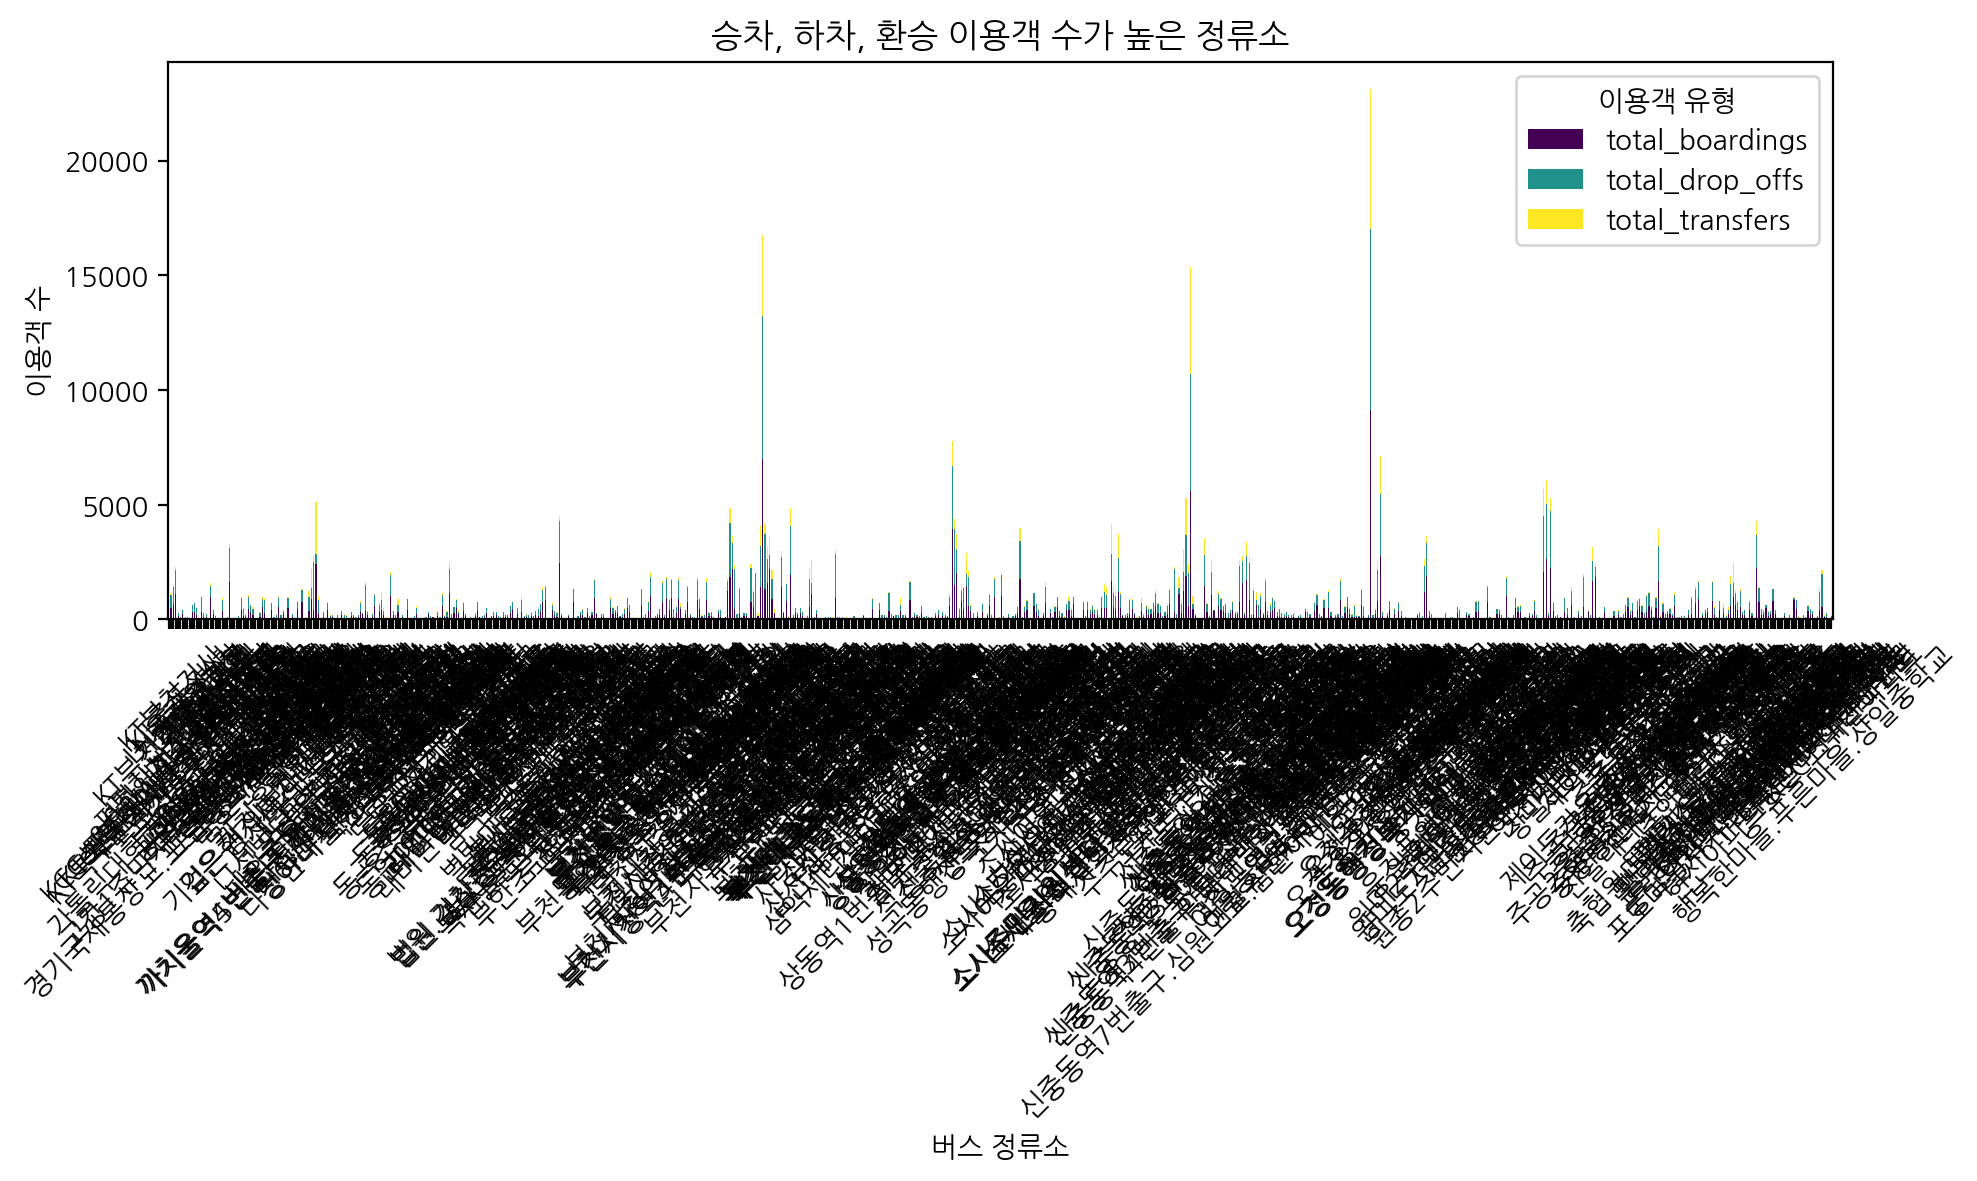

ModuleNotFoundError: No module named 'ace_tools'

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
bus_stop_data = pd.read_csv('/content/drive/MyDrive/my_project/버스_승차+하차+환승_2024_08_09.csv')
bus_stop_data=bus_stop_data[bus_stop_data['run_ymd']==20230701 ]

# Summarize the data by bus stop name
summary_data = bus_stop_data.groupby('bus_stop_hnm').agg({
    'total_boardings': 'sum',
    'total_drop_offs': 'sum',
    'total_transfers': 'sum',
    'total_passenger_count': 'sum'
}).reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))
summary_data.plot(
    x='bus_stop_hnm',
    y=['total_boardings', 'total_drop_offs', 'total_transfers'],
    kind='bar',
    stacked=True,
    colormap='viridis',
    ax=plt.gca()
)
plt.title('승차, 하차, 환승 이용객 수가 높은 정류소')
plt.xlabel('버스 정류소')
plt.ylabel('이용객 수')
plt.xticks(rotation=45)
plt.legend(title='이용객 유형')
plt.tight_layout()
plt.show()

# Grouping the stops based on total passenger count
passenger_groups = summary_data.copy()
passenger_groups['group'] = pd.cut(
    passenger_groups['total_passenger_count'],
    bins=[0, 5000, 10000, 15000],
    labels=['Low', 'Medium', 'High']
)

import ace_tools as tools; tools.display_dataframe_to_user(name="Bus Stop Passenger Data Grouped", dataframe=passenger_groups)

<Axes: xlabel='bus_stop_hnm'>

Text(0.5, 1.0, 'Top 10 정류소: 승차 승객 수')

Text(0.5, 0, '버스 정류소')

Text(0, 0.5, '승차 승객 수')

<Axes: xlabel='bus_stop_hnm'>

Text(0.5, 1.0, 'Top 10 정류소: 하차 승객 수')

Text(0.5, 0, '버스 정류소')

Text(0, 0.5, '하차 승객 수')

<Axes: xlabel='bus_stop_hnm'>

Text(0.5, 1.0, 'Top 10 정류소: 환승 승객 수')

Text(0.5, 0, '버스 정류소')

Text(0, 0.5, '환승 승객 수')

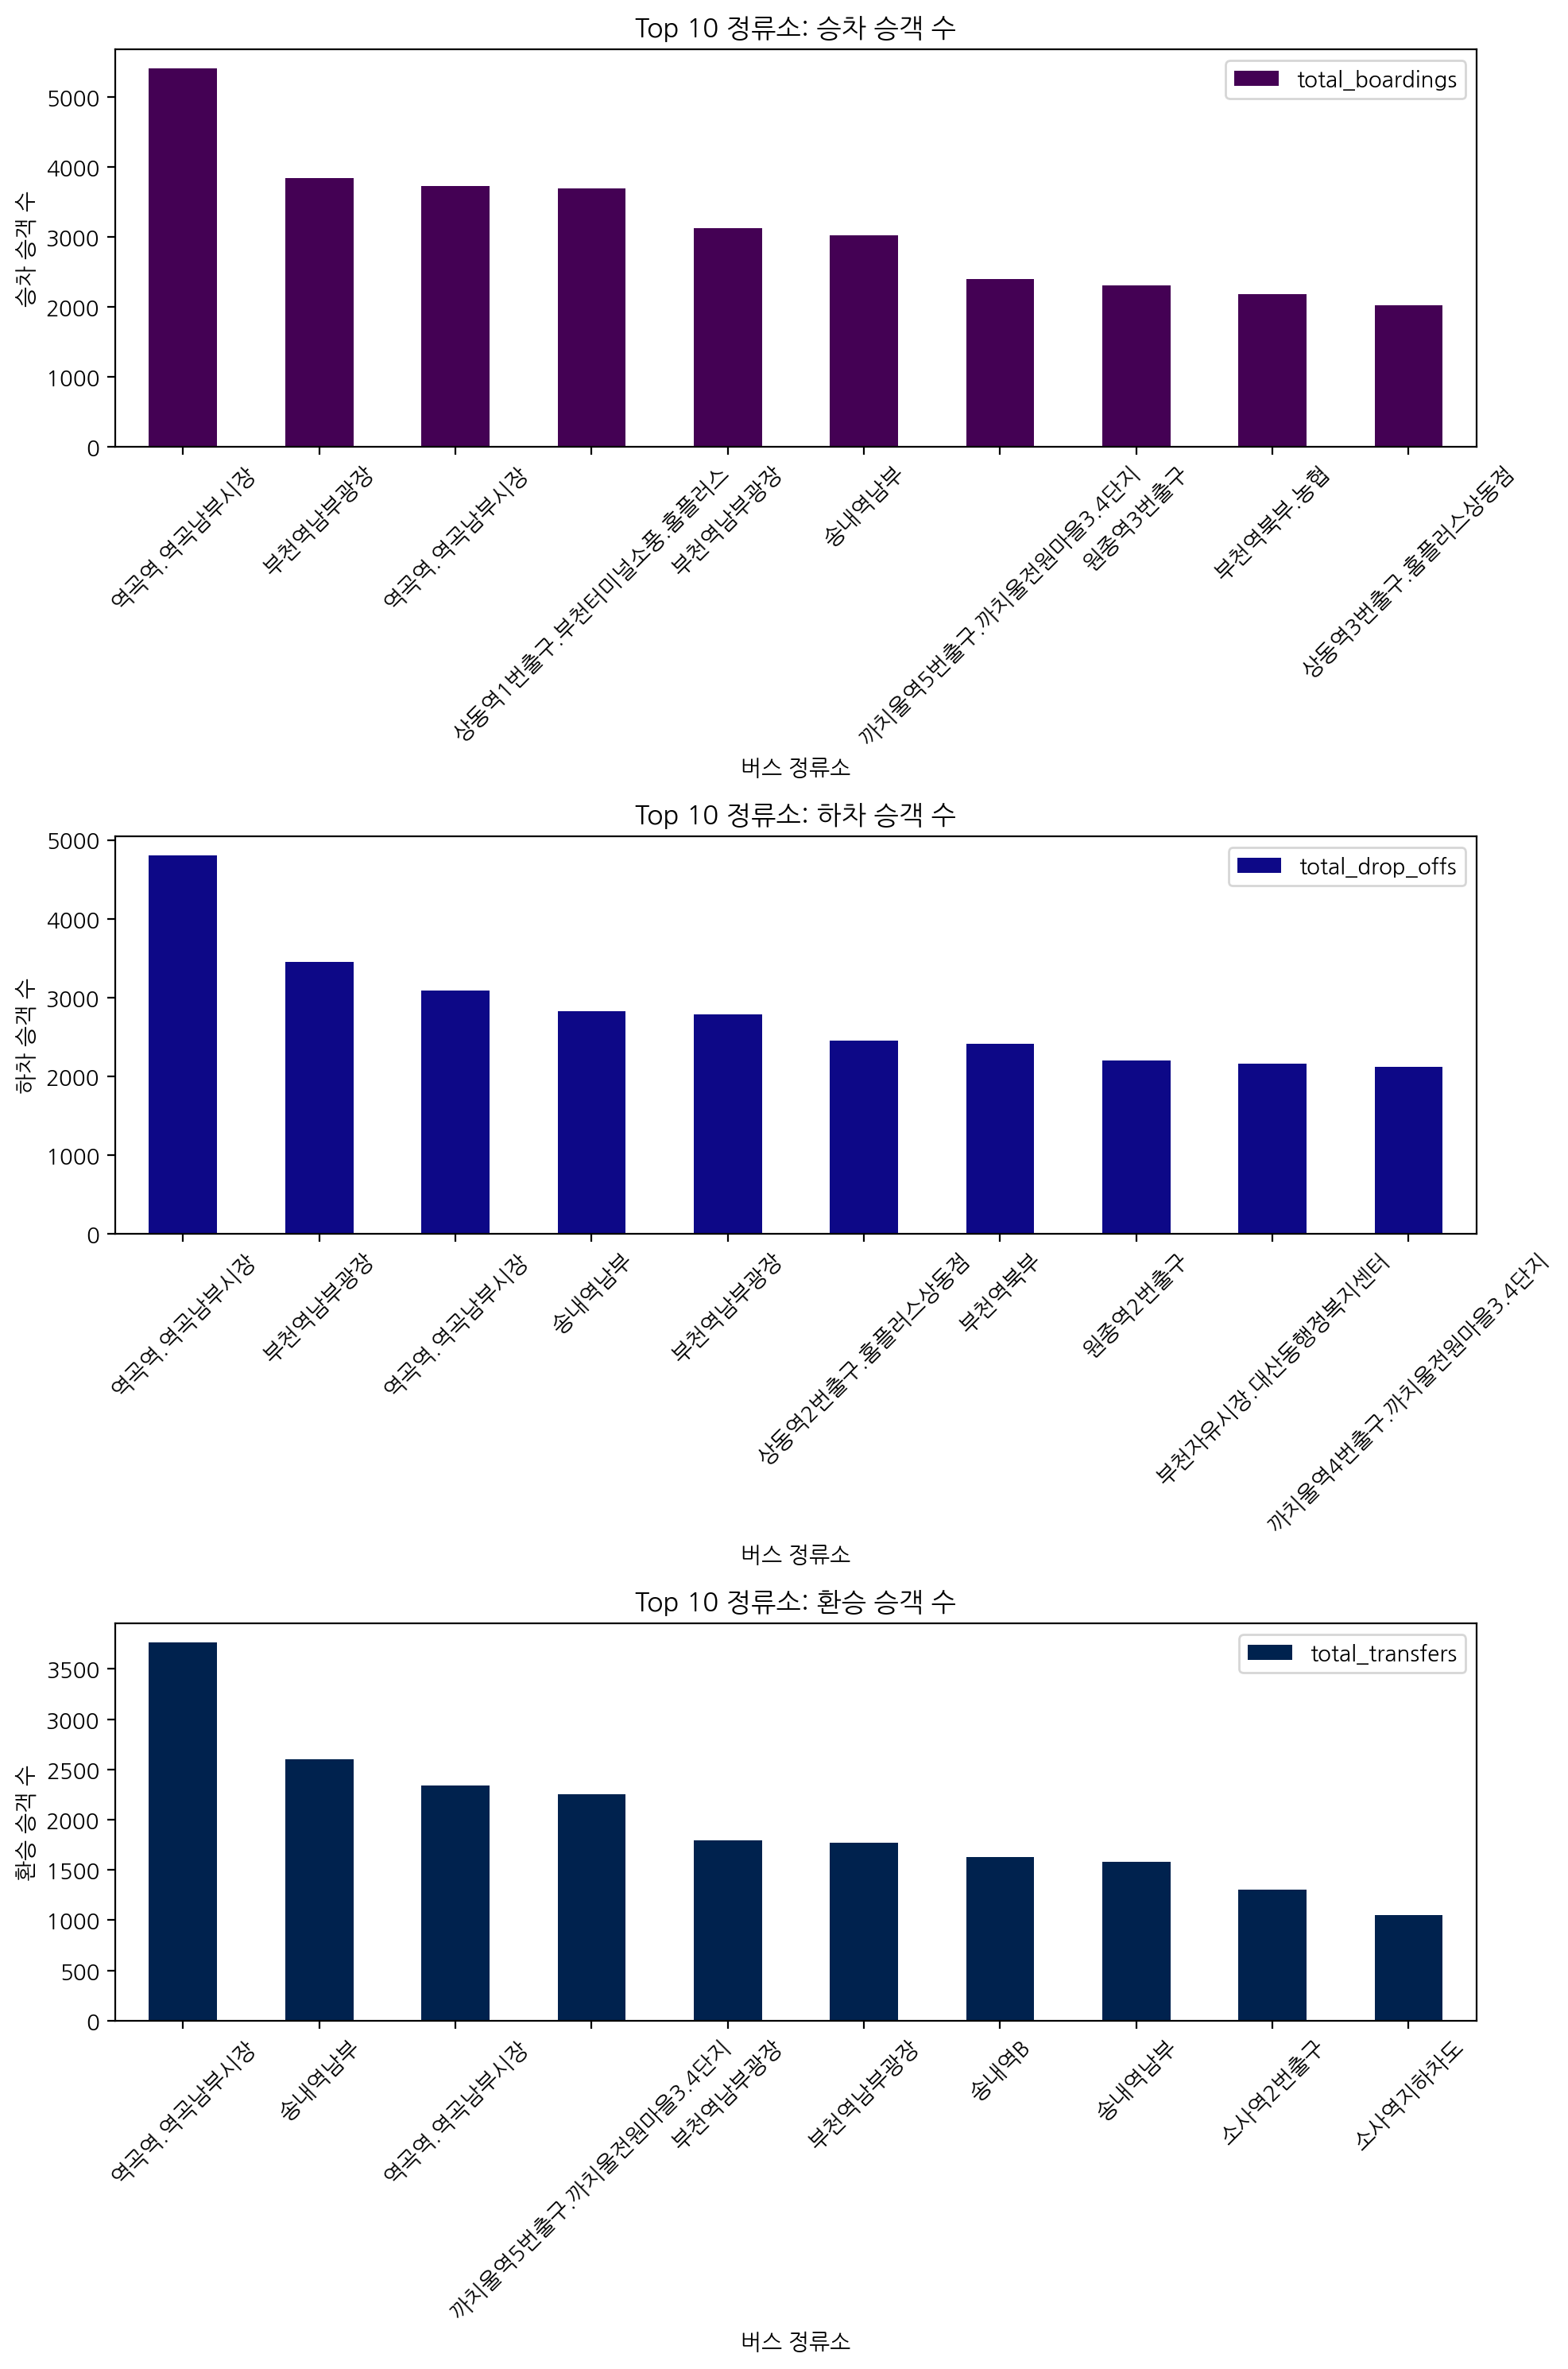

In [32]:
# Identifying top 10 bus stops for each category: total_boardings, total_drop_offs, total_transfers

# Top 10 for boardings
top_boardings = bus_stop_data.nlargest(10, 'total_boardings')[['bus_stop_hnm', 'total_boardings']]

# Top 10 for drop-offs
top_drop_offs = bus_stop_data.nlargest(10, 'total_drop_offs')[['bus_stop_hnm', 'total_drop_offs']]

# Top 10 for transfers
top_transfers = bus_stop_data.nlargest(10, 'total_transfers')[['bus_stop_hnm', 'total_transfers']]

# Plotting each category
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot for top boardings
top_boardings.plot(
    x='bus_stop_hnm',
    y='total_boardings',
    kind='bar',
    ax=axes[0],
    colormap='viridis'
)
axes[0].set_title('Top 10 정류소: 승차 승객 수')
axes[0].set_xlabel('버스 정류소')
axes[0].set_ylabel('승차 승객 수')
axes[0].tick_params(axis='x', rotation=45)

# Plot for top drop-offs
top_drop_offs.plot(
    x='bus_stop_hnm',
    y='total_drop_offs',
    kind='bar',
    ax=axes[1],
    colormap='plasma'
)
axes[1].set_title('Top 10 정류소: 하차 승객 수')
axes[1].set_xlabel('버스 정류소')
axes[1].set_ylabel('하차 승객 수')
axes[1].tick_params(axis='x', rotation=45)

# Plot for top transfers
top_transfers.plot(
    x='bus_stop_hnm',
    y='total_transfers',
    kind='bar',
    ax=axes[2],
    colormap='cividis'
)
axes[2].set_title('Top 10 정류소: 환승 승객 수')
axes[2].set_xlabel('버스 정류소')
axes[2].set_ylabel('환승 승객 수')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()